In [1]:
import pandas as pd
import datetime
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

In [2]:
def date(str): 
    return str[:10]

def timestamp_to_string(time): 
    return time.strftime("%d/%m/%Y")

In [3]:
broadband_SPL = pd.read_feather(r'X:\Physics\StudentProjects\MPhys\2021-22\Acoustics\GM_data\whole_year.feather')
broadband_SPL.head()

,timestamp,broadband_spl,background_spl
0,2018-08-02 00:08:03.500,-57.607837,-56.670380
1,2018-08-02 00:08:04.000,-57.849402,-56.669828
2,2018-08-02 00:08:04.500,-58.041780,-56.669340
3,2018-08-02 00:08:05.000,-57.718385,-56.668625
4,2018-08-02 00:08:05.500,-57.395894,-56.667946


In [4]:
broadband_SPL['date'] = broadband_SPL['timestamp'].apply(timestamp_to_string)
#broadband_SPL['date'] = broadband_SPL['timestamp'].apply(date)        

In [5]:
daily_broadband_SPL = broadband_SPL.groupby(by='date').mean() 

In [6]:
daily_broadband_SPL.reset_index(inplace=True)
daily_broadband_SPL.sort_values(by='date', inplace=True)
daily_broadband_SPL['date'] = pd.to_datetime(daily_broadband_SPL['date'], dayfirst=True)

In [7]:
#dataframe with daily temperature data from Oceans2.0 website
folder_path = r'C:\Users\hjh44\OneDrive - University of Bath\Masters Project\Temperature\\'

d = {}  # dictionary that will hold dataframes for each month  
month_array = ['August', 'September', 'October', 'November', 'December', 'January', 'February', 'March', 'April', 'May', 'June', 'July']

path = folder_path + 'ShoreStation_MeteorologicalStation-Lufft_MeteorologicalStation_AirTemperature_20180801T000000Z_20190530T235900Z-NaN_clean.csv'
temp_data = pd.read_csv(path, skiprows=52)

#formatting 
temp_data.drop(temp_data.index[[0]], inplace=True)                                 #drop first row with no data 
temp_data = temp_data.iloc[: , :-3]                                                #remove last 3 columns
temp_data.set_axis(['Time', 'Air Temp', 'Flag'], axis=1, inplace=True)             #rename columns
temp_data['Date'] = temp_data['Time'].apply(date)                                  #just get date

temp_data['Date'] = pd.to_datetime(temp_data['Date'], dayfirst=True)               #convert to timestamp  
temp_data['Air Temp'] = temp_data['Air Temp'].astype(float)                        #convert to float 
daily_temp = temp_data.groupby(by='Date').mean()                                   #new df for daily average temp 
daily_temp.reset_index(inplace=True)                                               #reset index

#add temperature change column 
daily_temp['Temp Change'] = np.nan
for i in range(0, len(daily_temp)-1): 
    daily_temp.loc[i+1, 'Temp Change'] = (daily_temp.loc[i+1, 'Air Temp']) - (daily_temp.loc[i, 'Air Temp'])
    
daily_temp.head()

,Date,Air Temp,Flag,Temp Change
0,2018-08-01,7.801555,1.000000,NaN
1,2018-08-02,6.107467,1.000000,-1.694088
2,2018-08-03,6.299008,1.016667,0.191541
3,2018-08-04,8.332302,1.000000,2.033295
4,2018-08-05,7.277796,1.000000,-1.054506


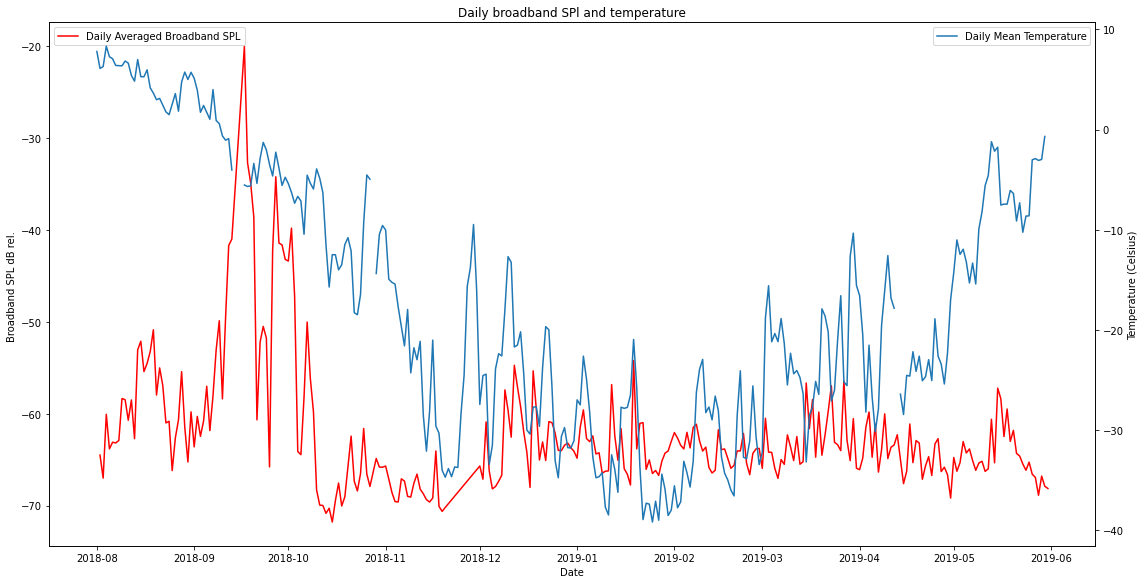

In [8]:
fig, ax = plt.subplots(figsize=(16,8))
daily_broadband_SPL.sort_values('date', inplace=True)
ax.plot(daily_broadband_SPL['date'], daily_broadband_SPL['broadband_spl'], label='Daily Averaged Broadband SPL', c='r')

ax2 = ax.twinx()
ax2.plot(daily_temp['Date'], daily_temp['Air Temp'], label='Daily Mean Temperature')
#ax2.plot(temp['Date'], temp['Temp Change'], label='Temperature change')
#ax2.hlines(y=0, xmin=pd.to_datetime('2018/08/01'), xmax=pd.to_datetime('2019/05/30'), ls='--', label='ice melting point')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.set_ylabel('Broadband SPL dB rel. ')
ax2.set_ylabel('Temperature (Celsius)')
ax.set_xlabel('Date')

plt.tight_layout()
plt.title('Daily broadband SPl and temperature')
plt.show()

In [9]:
daily_temp['broadband_SPL'] = np.nan

for i in range(0, len(daily_temp)-1): 
    date = daily_temp.loc[i, 'Date']
    
    for j in range(0, len(daily_broadband_SPL)): 
        if daily_broadband_SPL.loc[j, 'date'] == date: 
            broadband_SPL  = daily_broadband_SPL.loc[j, 'broadband_spl']
            
    daily_temp.loc[i, 'broadband_SPL'] = broadband_SPL 

In [10]:
daily_broadband_SPL.sort_values('date')            #sort values 
daily_temp = daily_temp.drop_duplicates(['Date'])  #check dates - there are overlap in dates, causing duplicates
daily_temp.dropna(inplace=True)                    #remove nan values 

In [11]:
#CORRELATIONS
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [12]:
#whole year
data1 = np.array(daily_temp['broadband_SPL'])
data2 = np.array(daily_temp['Air Temp'])

corr, _ = spearmanr(data1, data2)
print('Spearmans correlation between broadband SPL and temperature: %.3f' % corr)

Spearmans correlation between broadband SPL and temperature: 0.308


In [13]:
#split between times of cooling (decreasing temperatures) and warming (increasing temperatures)

In [14]:
#cooling 
cooling = daily_temp[daily_temp['Date'] < pd.to_datetime('01/02/2019')]
data1 = np.array(cooling['broadband_SPL'])
data2 = np.array(cooling['Air Temp'])

corr, _ = spearmanr(data1, data2)
print('Spearmans correlation between broadband SPL and temperature: %.3f' % corr)

Spearmans correlation between broadband SPL and temperature: 0.524


In [15]:
#warming
warming = daily_temp[daily_temp['Date'] >= pd.to_datetime('01/02/2019')]
data1 = np.array(warming['broadband_SPL'])
data2 = np.array(warming['Air Temp'])

corr, _ = spearmanr(data1, data2)
print('Spearmans correlation between broadband SPL  events and temperature: %.3f' % corr)

Spearmans correlation between broadband SPL  events and temperature: -0.041


In [27]:
#time with ice 
ice_present = daily_temp[daily_temp['Date'] > pd.to_datetime('01/11/2018', dayfirst=True)]
data1 = np.array(ice_present['broadband_SPL'])
data2 = np.array(ice_present['Air Temp'])

corr, _ = spearmanr(data1, data2)
print('Spearmans correlation between broadband SPL  events and temperature: %.3f' % corr)

Spearmans correlation between broadband SPL  events and temperature: -0.005


In [24]:
#time with no ice 
no_ice_present = daily_temp[daily_temp['Date'] < pd.to_datetime('01/11/2018', dayfirst=True)]
data1 = np.array(no_ice_present['broadband_SPL'])
data2 = np.array(no_ice_present['Air Temp'])

corr, _ = spearmanr(data1, data2)
print('Spearmans correlation between broadband SPL  events and temperature: %.3f' % corr)

Spearmans correlation between broadband SPL  events and temperature: 0.235
